In [ ]:
from torchvision.models.segmentation.segmentation import fcn_resnet50

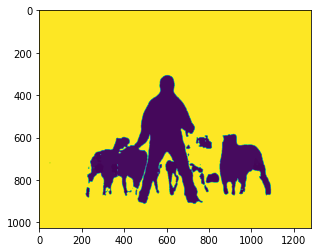

In [28]:
#Пример того как натренированная модель fcn умеет отделять бэкграунд от объектов
# мы хоти чтобы бэкграунда у нас считалось все кроме кошачьего носика
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/deeplab1.png", "deeplab1.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)


from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

model = fcn_resnet50(pretrained=True, progress=True, num_classes=21)
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)
import matplotlib.pyplot as plt
tl = output_predictions
tl[tl==0] = 255
plt.imshow(output_predictions)

In [ ]:
#!g1.1
%pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f
%pip install pandas==1.3.3

In [1]:
import shutil
import os

In [2]:
EPOCHES = 10

In [3]:
train_data = ['./training_data/image_' + str(i) + '.jpg' for i in range(30)]
train_labels = ['./training_labels/nose_mask' + str(i)+ '.jpg' for i in range(30)]

In [4]:
def transform_image(img_path):
    img = cv2.imread(img_path) / 255
    img = torch.tensor(img, dtype=torch.float32)
    img = torch.transpose(torch.transpose(img, 1, 2), 0, 1)
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
    return img.unsqueeze(0)

In [ ]:
def transform_target(img_path):
    img = cv2.imread(img_path) / 255
    img = torch.tensor(img, dtype=torch.float32)[:, :, 0]
    img = img.unsqueeze(0).expand((1, img.shape[0], img.shape[1]))
    return img.unsqueeze(0)

In [ ]:
images_dataset = [{'input':transform_image(train_data[i]), 'target':transform_target(train_labels[i])}
                  for i in range(len(train_data))]

In [6]:
model = fcn_resnet50(pretrained=True, progress=True, num_classes=21)
#поскольку мы хотим файнтюнить натренированную модель, придется мириться с 21 классом вместо требуемых 2
#однако мы знаем, что 0-й выходной фрейм отвечает за бэкраунд, поэтому будем считать что argmax по всем слоям должен научиться отделять нос от бэкраунда
#либо можно накинуть еще один слой: (линейный либо активация + линейный, который как раз разобьет на два класса)
#спойлер: ни одна из этих моделей не сможет работать так же хорошо, как datasetGAN

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

In [60]:
import torch.nn as nn
import torch

class FCN_2class(nn.Module):
    def __init__(self):
        super(FCN_2class, self).__init__()

        self.fcn_resnet50 = fcn_resnet50(pretrained=True, progress=True, num_classes=21)
        self.conv = nn.Sequential(nn.LeakyReLU(), nn.Conv2d(21, 2, 3, (1, 1), (1, 1)))
        # self.conv = nn.Conv2d(21, 1, 3)

    def forward(self, input):
        out = self.fcn_resnet50(input)['out']
        out = self.conv(out)
        return out         


torch.Size([1, 21, 256, 256])


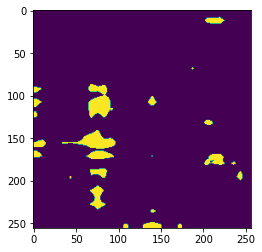

In [61]:
#example of the output mask for random input

# example_model = FCN_2class()
# out = example_model(tt).detach()
example_model = fcn_resnet50(pretrained=True, progress=True, num_classes=21)
out = example_model(tt)['out'].detach()
print(out.shape)
out = out.argmax(1)
out = out/(out + 1e-5)
plt.imshow(out[0])

In [ ]:
criterion = nn.MSELoss()
EPOCH_SIZE = 32
EPOCHES = 5
from random import sample
from tqdm import tqdm

In [18]:
model = fcn_resnet50(pretrained=True, progress=True, num_classes=21)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model.train(True)
running_loss = 0
for epoch in tqdm(range(EPOCHES)):
    for epoch_size in range(EPOCH_SIZE):
        idx = sample(range(len(images_dataset)), 1)[0]
        input, target = images_dataset[idx]['input'], images_dataset[idx]['target']
        data = input#.to('cuda')
        target = target#.to('cuda')
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        if model.__class__ == FCN_2class:
          outputs = model(data)
        else:
          outputs = model(data)['out']
        outputs = outputs.argmax(1) 
        outputs =  outputs / (outputs + 1e-5) #all classes except for zero  background label as 1
        #делим чтобы все классы кроме нулевого считались первым классом
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item()
#         except RuntimeError:
#             print("RuntimeError, data.shape=", data.shape, "target.shape=", target.shape, "outputs.shape", outputs.shape)
    epoch_loss = running_loss / EPOCH_SIZE
    print(epoch , epoch_loss)

In [ ]:
test_data = ['./testing_data/cat_' + str(i) + '.png' for i in range(20)]
test_gan_labels = ['./test_gan_labels/nose_mask' +  str(i) + '.jpg' for i in range(20)]

In [ ]:
test_dataset = [{'input':transform_image(test_data[i]), 'target':transform_target(test_gan_labels[i])}
                  for i in range(len(test_data))]

In [ ]:
idexes = np.argwhere(image) < 0.5
# idexes = idexes.T
idexes.shape

(2, 204000)

In [ ]:
idexes

array([[ True,  True,  True, ..., False, False, False],
       [ True, False, False, ..., False, False, False]])

In [ ]:
image[image> 0.5]

array([0.5019018, 0.5039938, 0.5060857, ..., 0.5105272, 0.5105272,
       0.5105272], dtype=float32)

In [ ]:
model.eval()
with torch.no_grad():
  for idx, data in enumerate(test_dataset):
      input = data['input']
      target = data['target']
      target = torch.mean(target, dim=1)
      if model.__class__ == FCN_2class:
          outputs = model(data)
        else:
          outputs = model(data)['out']
      image = outputs.argmax(1)
      image[image > 0] = 255
      a = image.astype(int)
      cv2.imwrite(f'./testing_pred_labels/nose_mask{str(idx)}.jpg', a)